In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('ENB2012_data.xlsx')

In [3]:
column_names = {'X1':'Relative_Compactness', 'X2': 'Surface_Area', 
                'X3':  'Wall_Area', 'X4': 'Roof_Area', 'X5': 'Overall_Height',
                'X6': 'Orientation', 'X7': 'Glazing_Area', 
                'X8': 'Glazing_Area_Distribution', 
                'Y1': 'Heating_Load', 'Y2': 'Cooling_Load'}

In [4]:
df = df.rename(columns=column_names)

In [5]:
simple_linear_reg_df = df[['Relative_Compactness', 'Cooling_Load']]

In [6]:
print(simple_linear_reg_df)

     Relative_Compactness  Cooling_Load
0                    0.98         21.33
1                    0.98         21.33
2                    0.98         21.33
3                    0.98         21.33
4                    0.90         28.28
..                    ...           ...
763                  0.64         21.40
764                  0.62         16.88
765                  0.62         17.11
766                  0.62         16.61
767                  0.62         16.03

[768 rows x 2 columns]


<AxesSubplot:xlabel='Relative_Compactness', ylabel='Cooling_Load'>

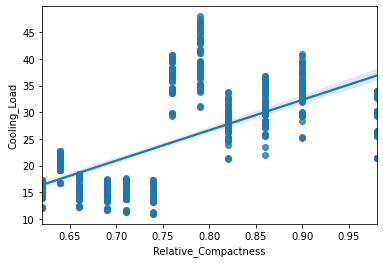

In [7]:
sns.regplot(x="Relative_Compactness", y="Cooling_Load", data=simple_linear_reg_df)

In [8]:
#Firstly, we normalise our dataset to a common scale using the min max scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalised_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
features_df = normalised_df.drop(columns=['Heating_Load', 'Cooling_Load'])
heating_target = normalised_df['Heating_Load']


#Now, we split our dataset into the training and testing dataset. Recall that we had earlier segmented the features and target variables.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features_df, heating_target, test_size=0.3, random_state=1)

from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
#fit the model to the training dataset
linear_model.fit(x_train, y_train)
#obtain predictions
predicted_values = linear_model.predict(x_test)


#MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predicted_values)
round(mae, 3) 	#prints 0.063

0.063

In [9]:
##### R_Squared #####
from sklearn.metrics import r2_score
r2_score = r2_score(y_test, predicted_values)
round(r2_score, 3)	#prints 0.893

0.894

In [10]:
##### Residual sum of square #####
import numpy as np
rss = np.sum(np.square(y_test - predicted_values))
round(rss, 3)	    #prints 1.823

1.817

In [11]:
##### Root mean square error  #####
from sklearn.metrics import  mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, predicted_values))
round(rmse, 3) 	#prints 0.089

0.089

In [12]:
cooling_target = normalised_df['Cooling_Load']

In [13]:
#comparing the effects of regularisation
def get_weights_df(model, feat, col_name):   
    #this function returns the weight of every feature
    weights = pd.Series(model.coef_, feat.columns).sort_values()
    weights_df = pd.DataFrame(weights).reset_index()
    weights_df.columns = ['Features', col_name]
    weights_df[col_name].round(3)
    return weights_df

linear_model_weights = get_weights_df(linear_model, x_train, 'Linear_Model_Weight')


In [14]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(x_train, y_train)

Lasso(alpha=0.001)

In [15]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=0.5)
ridge_reg.fit(x_train, y_train)

Ridge(alpha=0.5)

In [16]:
ridge_weights_df = get_weights_df(ridge_reg, x_train, 'Ridge_Weight')
lasso_weights_df = get_weights_df(lasso_reg, x_train, 'Lasso_weight')

final_weights = pd.merge(linear_model_weights, ridge_weights_df, on='Features')
final_weights = pd.merge(final_weights, lasso_weights_df, on='Features')

In [17]:
print(final_weights)

                    Features  Linear_Model_Weight  Ridge_Weight  Lasso_weight
0       Relative_Compactness            -0.606412     -0.283471     -0.027719
1                  Roof_Area            -0.328099     -0.163192     -0.000000
2               Surface_Area            -0.235022     -0.062275      0.000000
3                Orientation             0.003399      0.003369      0.000000
4                  Wall_Area             0.018947      0.103061      0.200087
5  Glazing_Area_Distribution             0.028452      0.029088      0.021431
6               Glazing_Area             0.215042      0.212449      0.206132
7             Overall_Height             0.393549      0.442467      0.463482
